# Random Forest

In [12]:
#Import core ML libraries for preprocessing, Random Forest training, and evaluation.
#Setting up environment

!pip -q install shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from time import perf_counter
import joblib
from joblib import Memory

try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("Environment ready. SHAP available:", SHAP_AVAILABLE)

Environment ready. SHAP available: True


## Load Dataset

Load the dataset, define the binary target, and drop identifier columns.
Converting y to 0/1 ensures downstream estimators and metrics behave as expected.
Explicitly handles missing values and class balance

In [13]:
# 1) Load data
df = pd.read_csv("wallacecommunications.csv")

# 2) Define target + features
TARGET = "new_contract_this_campaign"

# Drop ID as a unique identifer wouldn't normally be used as a predictor 
drop_cols = ["ID"]
X = df.drop(columns=[TARGET] + [c for c in drop_cols if c in df.columns])
y = df[TARGET]

# If target is "yes/no" strings, convert to 0/1
if y.dtype == "object":
    y = y.str.lower().map({"yes": 1, "no": 0, "y": 1, "n": 0, "true": 1, "false": 0}).astype("int")

# Quick data audit: column types, missingness, and class balance
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

# Identify likely binary numeric features (optional)
binary_num_cols = [c for c in num_cols if X[c].nunique(dropna=True) == 2]

print(f"Total features: {X.shape[1]}")
print(f"Categorical features: {len(cat_cols)}")
print(f"Numeric features: {len(num_cols)}")
print(f"Binary numeric features (subset of numeric): {len(binary_num_cols)}")

# Missing values summary
missing = X.isna().sum().sort_values(ascending=False)
print("\nMissing values (only columns with >0 missing):")
print(missing[missing > 0].head(25))

# Target class balance
print("\nTarget class balance (counts):")
print(y.value_counts(dropna=False))
print("\nTarget class balance (proportions):")
print(y.value_counts(normalize=True, dropna=False).round(4))

Total features: 18
Categorical features: 11
Numeric features: 7
Binary numeric features (subset of numeric): 0

Missing values (only columns with >0 missing):
Series([], dtype: int64)

Target class balance (counts):
new_contract_this_campaign
0    40763
1     9899
Name: count, dtype: int64

Target class balance (proportions):
new_contract_this_campaign
0    0.8046
1    0.1954
Name: proportion, dtype: float64


## Split strategy

Split data into train/val/test with stratification to keep class balance consistent.
We also identify categorical vs numeric columns for column-wise preprocessing.

In [14]:
# 3) Train / Val / Test split (e.g., 60/20/20)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)  # 0.25 of 0.80 = 0.20

# 4) Identify column types
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

## Preprocessing pipelines:

- Numeric: median imputation.
- Categorical: most-frequent imputation + one-hot encoding.

ColumnTransformer applies the right pipeline per column type without leakage.


In [15]:
# 5) Preprocessing
# - Numeric: median imputation
# - Categorical: most_frequent imputation + one-hot encoding
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

## Random Forest model in a Pipeline.

class_weight='balanced' helps when the positive class is rarer.
param_dist defines the hyperparameter space explored by RandomizedSearchCV.


In [16]:
# 6) Random Forest model
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

# 7) Hyperparameter tuning (RandomizedSearchCV)
param_dist = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [8, 12, 16, 20],
    "model__min_samples_split": [5, 10, 20],
    "model__min_samples_leaf": [4, 8, 16],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5],
    "model__max_samples" : [0.6, 0.8, 1.0],
    "model__bootstrap": [True],
}

## Fitting the hyperparameter search

joblib.Memory caches preprocessing steps to speed up repeated CV fits.

cv=5 uses 5-fold cross-validation.

We export cv_results_ and the best pipeline for reporting and reuse, due to computational errors that I experienced.


In [17]:
memory = Memory("sk_cache", verbose=0)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pipe = Pipeline(
    steps=[("preprocess", preprocess), ("model", rf)],
    memory=memory
)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=1,
    verbose=1
)

t0 = perf_counter()
search.fit(X_train, y_train)
pd.DataFrame(search.cv_results_).to_csv("rf_cv_results.csv", index=False)
joblib.dump(search.best_estimator_, "best_rf_pipeline.joblib")
t1 = perf_counter()

print(f"Seconds for 5*15 = 75 fits:", t1 - t0)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Seconds for 5*15 = 75 fits: 597.0215956000029


Sanity check: confirm RandomizedSearchCV has been fit and produced results. (also due to errors that I experniced during working with random forest)

In [18]:
print("Has fit been run?", hasattr(search, "cv_results_"))
print("Any results?", getattr(search, "cv_results_", None) is not None)



Has fit been run? True
Any results? True


## Validation Evaluation

Validation at the default 0.5 threshold.
ROC-AUC summarises probability ranking; the classification report depends on the threshold.


In [19]:
# 8) Validate on the validation set
best_model = search.best_estimator_
val_proba = best_model.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)

print("\nValidation ROC-AUC:", roc_auc_score(y_val, val_proba))
print("\nValidation classification report:\n", classification_report(y_val, val_pred))



Validation ROC-AUC: 0.8344236551706194

Validation classification report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      8153
           1       0.55      0.61      0.58      1980

    accuracy                           0.83     10133
   macro avg       0.73      0.75      0.74     10133
weighted avg       0.83      0.83      0.83     10133


## Final Test

Final test evaluation after refitting on train+val.
Only evaluate on the test set once to avoid optimistic bias.
Confusion matrix plot to visualise false positives vs false negatives.


In [25]:
# 9) Refit best model on train+val, then evaluate on test
best_model.fit(X_trainval, y_trainval)

test_proba = best_model.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

print("\nTEST ROC-AUC:", roc_auc_score(y_test, test_proba))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

print("Best params:")
print(search.best_params_)


TEST ROC-AUC: 0.8504254491437123
[[7192  961]
 [ 736 1244]]
              precision    recall  f1-score   support

           0      0.907     0.882     0.894      8153
           1      0.564     0.628     0.595      1980

    accuracy                          0.833     10133
   macro avg      0.736     0.755     0.744     10133
weighted avg      0.840     0.833     0.836     10133

Best params:
{'model__n_estimators': 400, 'model__min_samples_split': 5, 'model__min_samples_leaf': 16, 'model__max_samples': 1.0, 'model__max_features': 0.5, 'model__max_depth': 16, 'model__bootstrap': True}


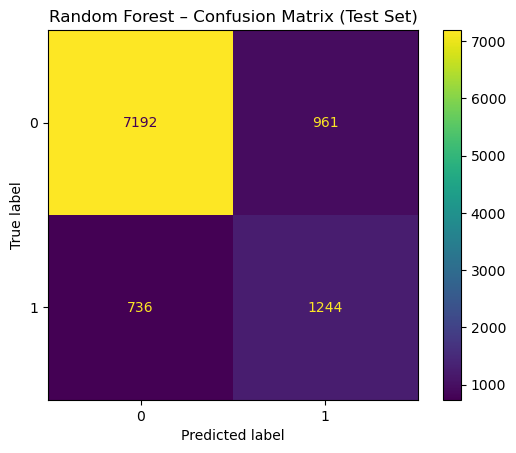

In [21]:
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format="d")
plt.title("Random Forest – Confusion Matrix (Test Set)")
plt.show()